# Module 7

## Video 33: Analysing Imports/Exports Data
**Python for the Energy Industry**

We will now extend the work of the previous lesson towards and example of analysing data on imports and exports.


[Cargo Time Series documentation.](https://vortechsa.github.io/python-sdk/endpoints/cargo_timeseries/)


In [1]:
# initial imports
from datetime import datetime

from dateutil.relativedelta import relativedelta

import vortexasdk as v

# The cargo unit for the time series (barrels)
TS_UNIT = "b"

# The granularity of the time series
TS_FREQ = "day"
# datetimes to access last 7 weeks of data
now = datetime.utcnow()
seven_weeks_ago = now - relativedelta(weeks=7)

Let's grab the Chinese imports data, as we did in the previous lesson:

In [2]:
# Find China ID
china = [g.id for g in v.Geographies().search("china").to_list() if "country" in g.layer]
assert len(china) == 1

search_result = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_destinations=china,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    filter_activity="unloading_state",
)

imports_df = search_result.to_df().rename(columns={"key":"date","value":"total"})[["date","total"]]

In [3]:
imports_df.head()

,date,total
0,2020-10-23 00:00:00+00:00,40022773
1,2020-10-24 00:00:00+00:00,47899427
2,2020-10-25 00:00:00+00:00,41827724
3,2020-10-26 00:00:00+00:00,44226467
4,2020-10-27 00:00:00+00:00,43840099


Now we'll break this data up by the exporting shipping region. First, we get the names and IDs of each shipping region:

In [4]:
shipping_regions = [g for g in v.Geographies().search() if "shipping_region" in g["layer"]]

shipping_region_names = [sr["name"] for sr in shipping_regions]
shipping_region_IDs = [sr["id"] for sr in shipping_regions]

# zip into a dictionary
shipping_region_dict = dict(zip(shipping_region_names,shipping_region_IDs))
print(len(shipping_region_dict))

Loading from API: 9000it [00:01, 7264.12it/s]                           

40


We can now loop over each shipping region, and add the time series data for exported by that region on to our DataFrame.

In [5]:
for shipping_region in shipping_region_dict:
    search_result = v.CargoTimeSeries().search(
        timeseries_frequency=TS_FREQ,
        timeseries_unit=TS_UNIT,
        filter_destinations=china,
        filter_origins=shipping_region_dict[shipping_region],
        filter_time_min=seven_weeks_ago,
        filter_time_max=now,
        filter_activity="unloading_state",
    )

    df_sr = search_result.to_df()
    imports_df[shipping_region] = df_sr["value"]

Let's take a peek at the top exporting regions among Chinese imports:

In [6]:
imports_df.sum().sort_values(ascending=False).head(10)

total                       2431041659
MEG/AG                       866788361
Far East                     803025155
East Asia                    549184939
China (excl. HK & Macau)     422978179
North China                  250206821
West Africa                  225805648
South China                  172771358
Southeast Asia               154141100
USAC/USGC                    149115266
dtype: int64

Text(0, 0.5, 'exports to China (barrels)')

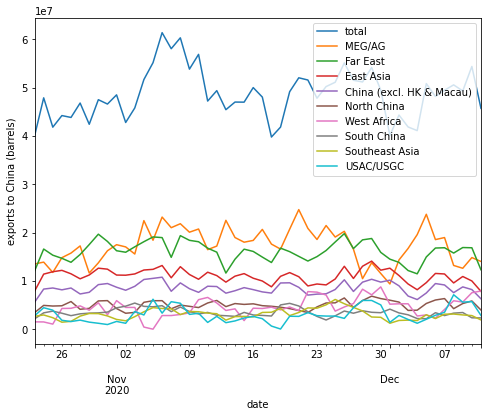

In [7]:
top10 = imports_df.sum().sort_values(ascending=False).head(10)

ax = imports_df.plot(x="date",y=top10.index.values,figsize=(8,6))
ax.set_ylabel("Imports to China (barrels)")

### Exercise

Try applying this analysis to US imports.